In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dtreeviz.trees import dtreeviz
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('data-last.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_109,Feature_110,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118
0,1,2,2,56,12,1,7.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,1,1,0
1,2,2,2,69,19,1,6.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,1
2,3,2,1,66,8,1,4.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0
3,4,2,2,62,16,1,NaN,3.0,0,1.0,...,1.0,0.0,1,0,1,1,0,0,1,1
4,5,2,2,67,30,1,NaN,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0


In [3]:
def train(df, trash_features = []):

    df_ = df.copy()

    target_feature = 'Result'
    golden_features = ['Feature_3', 'Feature_4', 'Feature_30', 'Feature_32', 'Feature_35', 'Feature_101']
    trash_features = trash_features
    all_features = df_.columns.drop([target_feature] + golden_features + trash_features + ['Id']).tolist()

    df_ = df_[[target_feature] + all_features]

    for col in df_.select_dtypes(include='float64').columns:
        df_.fillna(df_[col].mean(), inplace=True)

    for col in df_.select_dtypes(include='int64').columns:
        df_.fillna(-1, inplace=True)

    # Result=0 - alive, Result=1 died
    df_.loc[df_[target_feature] == 1, target_feature] = 1
    df_.loc[df_[target_feature] == 2, target_feature] = 0

    X = df_[all_features]
    y = df_[target_feature]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=True,
        test_size=0.1,
        random_state=0,
        stratify=y,
    )

    params_frozen = {
        'random_state': 0
    }

    params_grid = {
        'min_samples_leaf': [1, 2.5, 5],
        'max_depth': [3, 6, 10],
        'class_weight': ['None', 'balanced'],
    }

    clf = DecisionTreeClassifier(**params_frozen)
    gs = GridSearchCV(
        clf,
        params_grid,
        verbose=0
    )
    gs.fit(X_train, y_train)

    clf_final=DecisionTreeClassifier(**params_frozen, **gs.best_params_)
    clf_final.fit(
        X_train,
        y_train,
    )

    feature_importances = pd.DataFrame(
        zip(X_train.columns, clf_final.feature_importances_),
        columns=['feature_name', 'importance']
    )

    return clf_final, df_, X_train, X_test, y_train, y_test, all_features, target_feature, feature_importances

In [4]:
_, _, _, _, _, _, _, _, feature_importances = train(df_init)

clf_final, df, X_train, X_test, y_train, y_test, all_features, target_feature, feature_importances = train(
    df_init,
    trash_features=feature_importances[feature_importances['importance'] == 0 ]['feature_name'].tolist()
)

In [5]:
y_test_pred = clf_final.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')
print(f'\nConfusion matrix:\n {confusion_matrix(y_test, y_test_pred)}')

Accuracy: 0.73

Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.60      0.60      0.60         5

    accuracy                           0.73        15
   macro avg       0.70      0.70      0.70        15
weighted avg       0.73      0.73      0.73        15


Confusion matrix:
 [[8 2]
 [2 3]]


In [6]:
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
8,Feature_70,0.230320
2,Feature_29,0.210751
7,Feature_54,0.199958
4,Feature_39,0.175830
1,Feature_18,0.057920
6,Feature_51,0.044992
0,Feature_17,0.032796
5,Feature_45,0.029237
3,Feature_37,0.018197


Text(0.5, 1.0, 'Correlation with target variable')

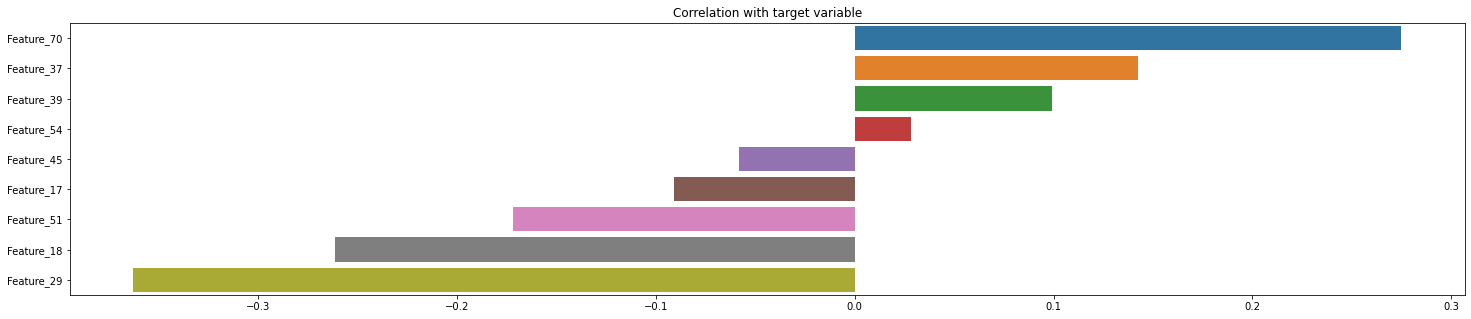

In [7]:
corr_with_target = df[all_features + [target_feature]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(25, 5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')

Text(0.5, 1.0, 'Correlation matrix')

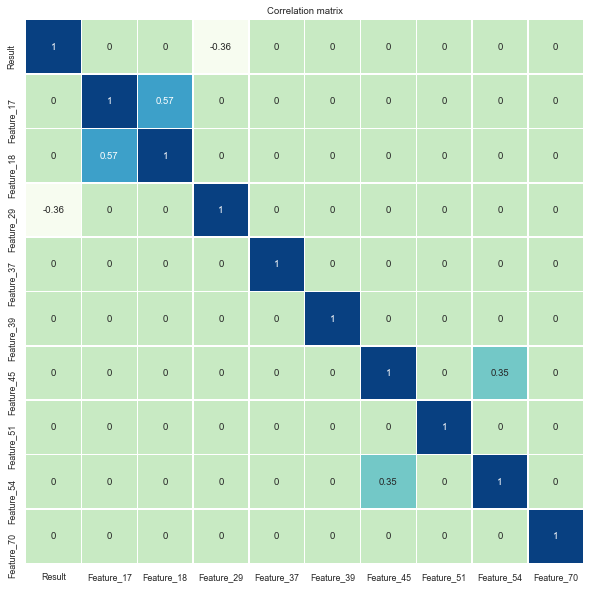

In [8]:
plt.figure(figsize = (10,10))
sns.set(font_scale=0.8)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu', cbar=False)
plt.title('Correlation matrix')

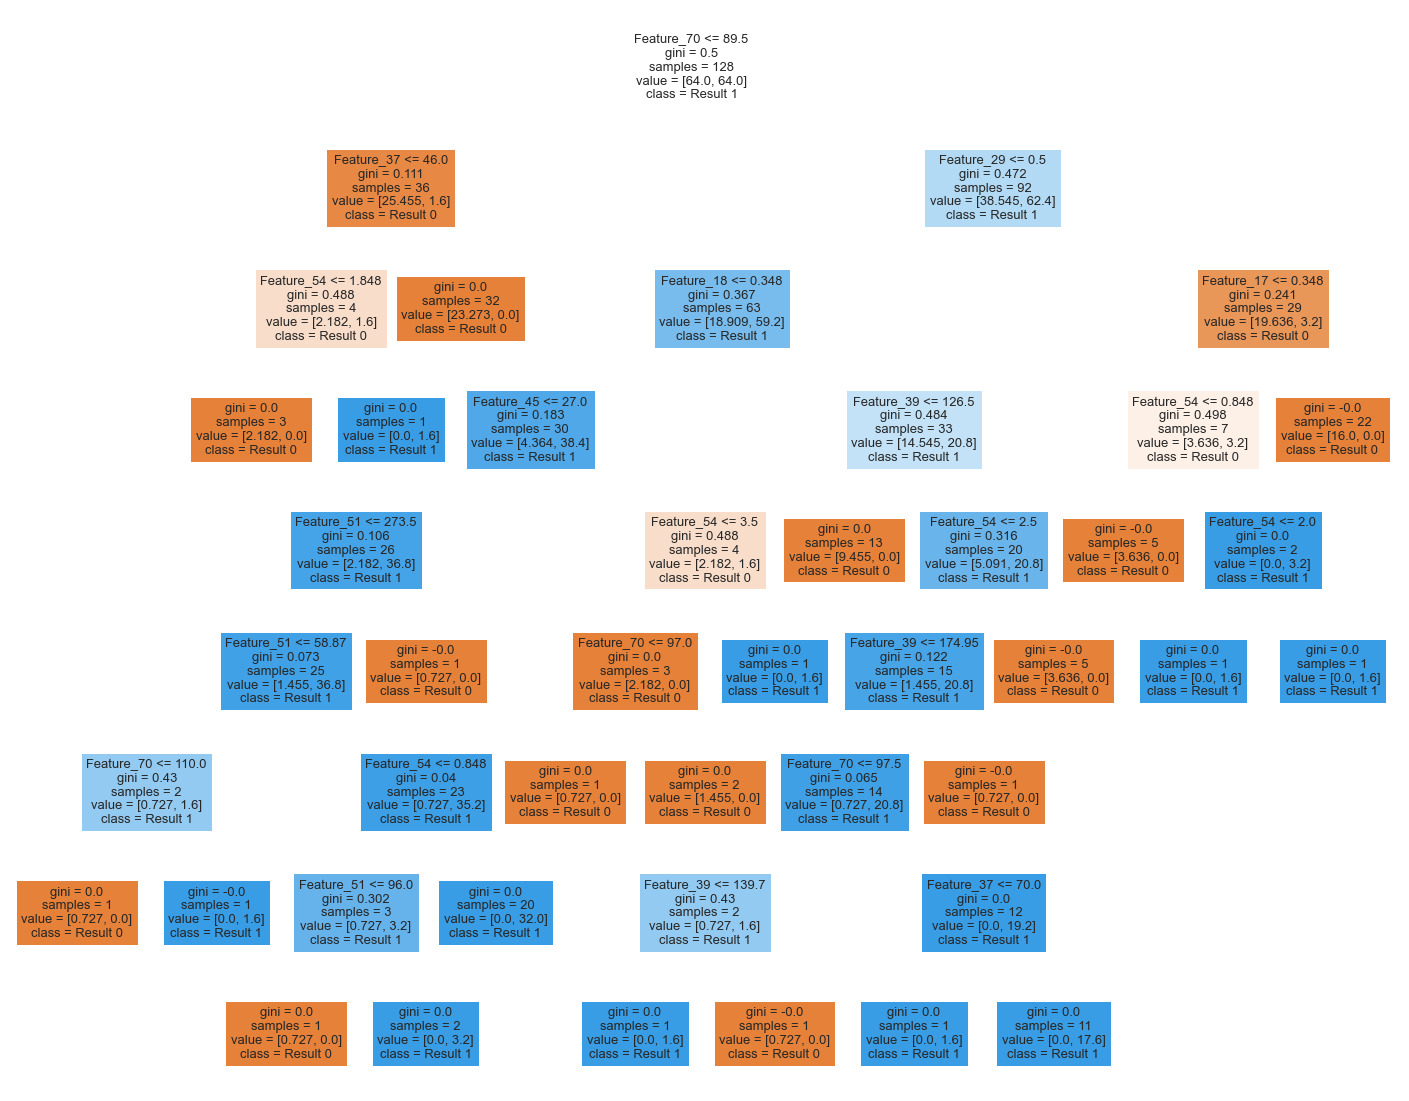

In [9]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(
    clf_final,
    feature_names=all_features,
    class_names=['Result 0', 'Result 1'],
    filled=True
)

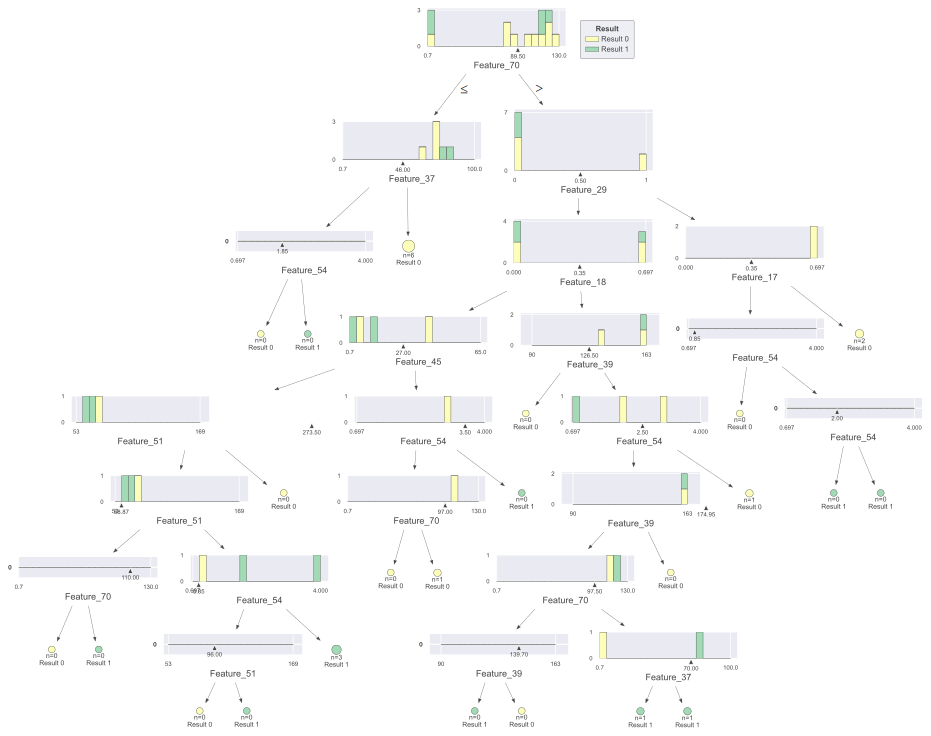

In [10]:
viz = dtreeviz(
    clf_final,
    X_test,
    y_test,
    target_name=target_feature,
    feature_names=all_features,
    class_names=['Result 0', 'Result 1']
)
viz